In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
import cv2 as cv
import os
import DarkArtefactRemoval as dca
import dullrazor as dr
import segmentation_and_preprocessing as sp
from tqdm import tqdm

In [2]:
# Répertoire contenant les images
image_dir_train = 'Train/Train/'
image_dir_test = 'Test/Test/'

Train_path = image_dir_train

import glob
images_train = glob.glob(Train_path + '/*[0-9].jpg')
mask_img_train = glob.glob(Train_path + '/*seg.png')

images_with_mask = [ Train_path + mask_img_train[i].split('/')[-1].split('_seg')[0] + '.jpg' for i in range(len(mask_img_train))]
images_test = glob.glob(image_dir_test + '/*[0-9].jpg')
mask_img_test = glob.glob(image_dir_test + '/*seg.png')

#Lire le csv metadataTrain et metadataTest
metadataTrain = pd.read_csv('metadataTrain.csv')
metadataTest = pd.read_csv('metadataTest.csv')



In [3]:
# Checking if the number of images is right 
print('There are', len(images_train),  'train images')
print('There are', len(images_with_mask),  'train images with mask')
print('There are', len(mask_img_train),  'train masks')
print('There are', len(images_test),  'test images')
print('There are', len(mask_img_test),  'test masks')

There are 18998 train images
There are 1945 train images with mask
There are 1945 train masks
There are 6333 test images
There are 648 test masks


In [4]:
X_train = glob.glob('output_masks_train_set_1/*.png')
X_train_names = [os.path.basename(x).split('.jpg_pred_mask.png')[0] for x in X_train]

# Get the names and classes as pandas Series
names_series = metadataTrain["ID"].loc[metadataTrain["ID"].isin(X_train_names)]
classes_series = metadataTrain["CLASS"].loc[metadataTrain["ID"].isin(X_train_names)]

# Convert the pandas Series to lists
names_list = names_series.tolist()
classes_list = classes_series.tolist()

X_train_ordered = []
X_train_ordered_names = []
for i in range(0, len(names_list)):
    for j in range(0, len(X_train_names)):
        if names_list[i] in X_train_names[j]:
            X_train_ordered.append(X_train[j])
            X_train_ordered_names.append(X_train_names[j])

In [6]:
X_train = [io.imread(x) for x in X_train_ordered]
X_train = np.array(X_train)

Asymmetry score: 0.4832689499753282


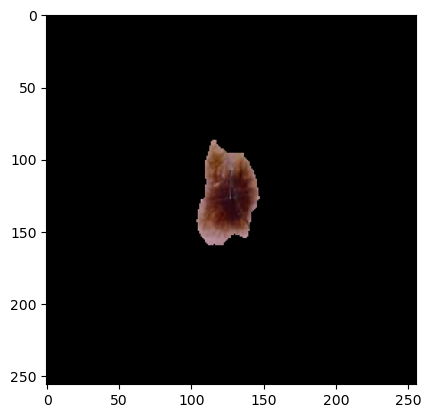

Asymmetry score: 0.26618822344789317


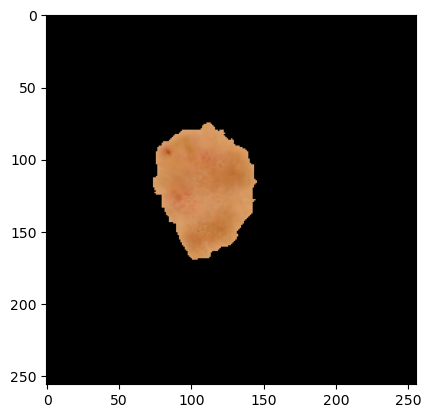

Asymmetry score: 0.6726147327144417


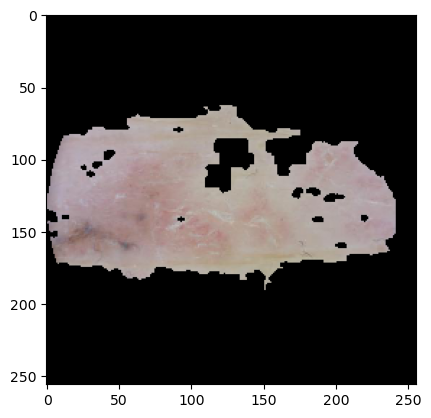

Asymmetry score: 0.1992135487476735


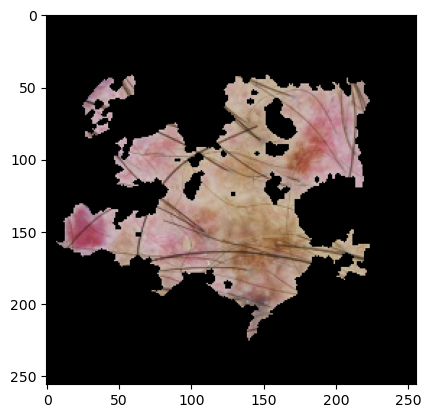

Asymmetry score: 0.01308947045836679


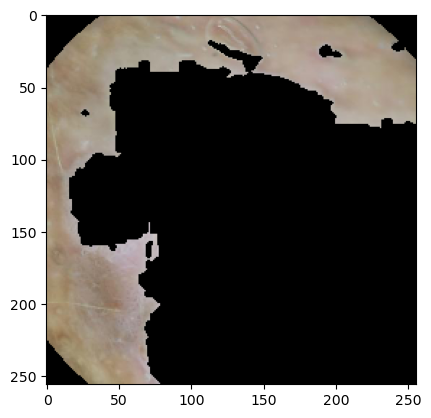

Asymmetry score: 0.43516327909195035


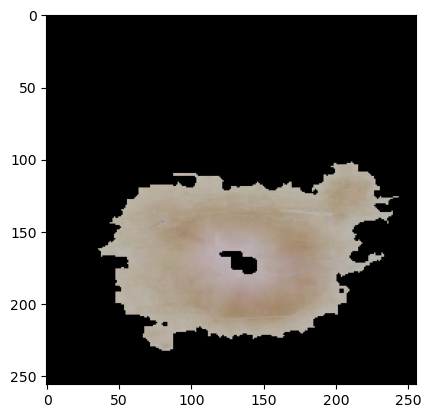

Asymmetry score: 0.48709528146565323


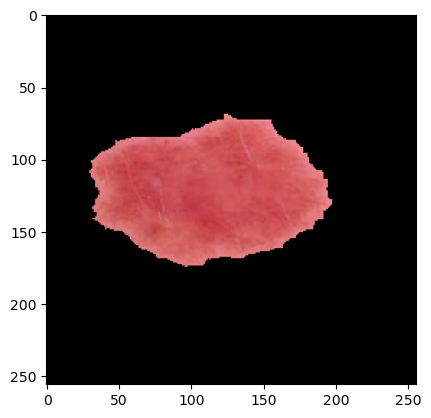

Asymmetry score: 0.21632513829032105


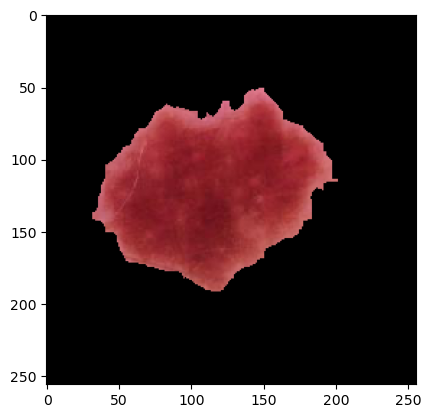

Asymmetry score: 0.49103170918723127


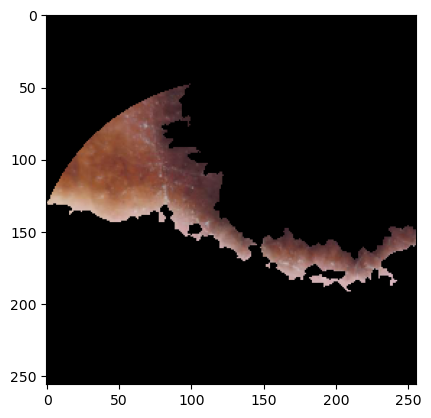

Asymmetry score: 0.33057497900013344


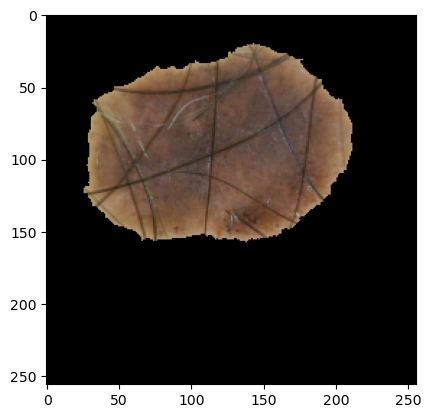

In [10]:
import numpy as np

def compute_asymmetry(image):
    # Convert image to numpy array
    image_array = np.array(image)
    
    # Calculate center of mass
    center_of_mass = np.array(np.where(image_array != 0)).mean(axis=1)
    
    # Shift coordinates so that center of mass is at the origin
    shifted_coords = np.array(np.where(image_array != 0)).T - center_of_mass
    
    # Calculate moments of shifted coordinates
    M11 = np.sum(shifted_coords[:, 0] * shifted_coords[:, 1])
    M20 = np.sum(shifted_coords[:, 0] ** 2)
    M02 = np.sum(shifted_coords[:, 1] ** 2)
    
    # Calculate asymmetry using moments
    asymmetry = np.abs(M20 - M02) / np.sqrt((M20 + M02) ** 2 + 4 * M11 ** 2)
    
    return asymmetry

# Example usage:
# Assuming 'image' is the gray-scale image of the lesion
for i in range(0, len(X_train[:10])):
    asymmetry_score = compute_asymmetry(X_train[i])
    print("Asymmetry score:", asymmetry_score)
    plt.imshow(X_train[i])
    plt.show()

(127.5, 127.5, 1.0)
(127.5, 127.5, 1.0)
(127.5, 127.5, 1.0)
(127.5, 127.5, 1.0)
(127.5, 127.5, 1.0)
(127.5, 127.5, 1.0)
(127.5, 127.5, 1.0)
(127.5, 127.5, 1.0)
(127.5, 127.5, 1.0)
9 9


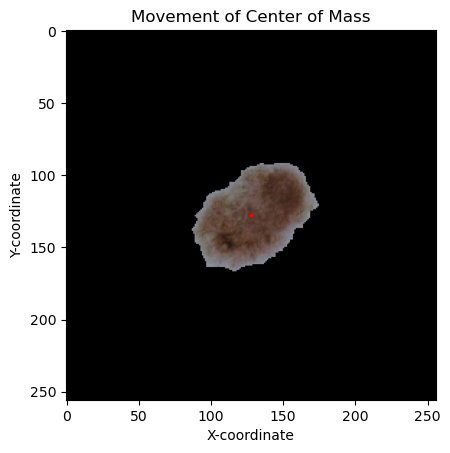

Mean distance: 0.12186295418199272
Standard deviation of distance: 0.0


In [37]:
import numpy as np
from scipy.ndimage import center_of_mass
from scipy.spatial.distance import cdist

def compute_center_mass_distances(lesion_segmente,image_mask, mask_thresholds):
    # Compute center of mass of the binary mask
    center_y, center_x = center_of_mass(image_mask)
    
    # Compute the area of the lesion mask
    lesion_area = np.sum(image_mask)
    
    # Compute the radius of a circle with equivalent area
    radius = np.sqrt(lesion_area / np.pi)
    
    # Initialize lists to store distances
    distances = []
    center_x_list = []
    center_y_list = []
    # Generate alternative binary masks and compute distances
    for threshold in mask_thresholds:
        # Generate binary mask using the threshold
        alternative_mask = (lesion_segmente >= np.percentile(lesion_segmente, threshold))
        print(center_of_mass(alternative_mask))
        # Compute mass center of the alternative mask
        alt_center_y, alt_center_x = center_of_mass(alternative_mask)[:2]
        center_x_list.append(alt_center_x)
        center_y_list.append(alt_center_y)

        # Compute Euclidean distance between (x, y) and (xt, yt)
        distance = np.sqrt((center_x - alt_center_x)**2 + (center_y - alt_center_y)**2)
        
        # Normalize distance by lesion-dependent constant (radius)
        normalized_distance = distance / radius
        
        # Append normalized distance to the list
        distances.append(normalized_distance)
    
    # Calculate mean and standard deviation of the normalized distances
    mean_distance = np.mean(distances)
    std_distance = np.std(distances)


    # Extract x and y coordinates of the center of mass
    x = center_x_list
    y = center_y_list
    print(len(x), len(y))

    # Create a scatter plot of the center of mass movement
    plt.imshow(lesion_segmente)
    plt.scatter(x, y, color='red', label='Center of Mass', s=2)

    

    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Movement of Center of Mass')
    plt.show()
    
    
    return mean_distance, std_distance

# Example usage:
# Assuming 'image' is the binary mask of the lesion
# Assuming 'mask_thresholds' is a list of thresholds (e.g., [10, 20, ..., 90])
lesion_segmente=io.imread('output_masks_train_set_1/ISIC_0000007.jpg_pred_mask.png')
image_mask = io.imread('Train/Train/ISIC_0000007_seg.png')
mean_distance, std_distance = compute_center_mass_distances(lesion_segmente,image_mask, [10, 20, 30, 40, 50, 60, 70, 80, 90])
print("Mean distance:", mean_distance)
print("Standard deviation of distance:", std_distance)


In [40]:
import numpy as np
from scipy.stats import f

def compute_ANOVA_percentiles(image, lesion_mask):
    # Define window size
    window_size = 61
    
    # Get border pixels
    border_pixels = np.argwhere(lesion_mask)
    
    # Initialize lists to store R values
    R_values = []
    
    # Iterate through border pixels
    for border_pixel in border_pixels:
        # Get coordinates of the sliding window centered at the border pixel
        start_row = border_pixel[0] - window_size // 2
        end_row = start_row + window_size
        start_col = border_pixel[1] - window_size // 2
        end_col = start_col + window_size
        
        # Extract pixels inside the sliding window
        window_pixels = image[start_row:end_row, start_col:end_col]
        
        # Flatten the window pixels and separate them into two groups: inside and outside lesion
        lesion_pixels = window_pixels[lesion_mask[start_row:end_row, start_col:end_col]]
        non_lesion_pixels = window_pixels[~lesion_mask[start_row:end_row, start_col:end_col]]
        
        # Compute ANOVA statistics
        mean_lesion = np.mean(lesion_pixels)
        mean_non_lesion = np.mean(non_lesion_pixels)
        var_lesion = np.var(lesion_pixels)
        var_non_lesion = np.var(non_lesion_pixels)
        
        # Compute R value
        R = (var_lesion / var_non_lesion) / (mean_lesion / mean_non_lesion)
        
        # Append R value to the list
        R_values.append(R)
    
    # Compute percentiles
    percentiles = np.percentile(R_values, [25, 50, 75])
    
    return percentiles

# Example usage:
# Assuming 'image' is the gray-scale version of the image
# Assuming 'lesion_mask' is the binary mask of the lesion
image = io.imread('Train/Train/ISIC_0000000.jpg')
image = cv.resize(image, (256, 256))
#grayscale version
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
lesion_mask = io.imread('output_masks_train_set_1/ISIC_0000000.jpg_pred_mask.png')
percentiles_f7_f8_f9 = compute_ANOVA_percentiles(image, lesion_mask)
print("25th percentile (f7):", percentiles_f7_f8_f9[0])
print("50th percentile (f8):", percentiles_f7_f8_f9[1])
print("75th percentile (f9):", percentiles_f7_f8_f9[2])


IndexError: index 150 is out of bounds for axis 0 with size 61

In [45]:
import numpy as np
from skimage.color import rgb2lab
from scipy.stats import describe

def compute_color_features(image, num_samples=256, bin_size=2):
    # Convert RGB image to CIE L*a*b* color space
    lab_image = rgb2lab(image)
    print(lab_image.shape)
    
    # Randomly select pixels from the lesion
    lesion_pixels = lab_image[np.random.choice(lab_image.shape[0], num_samples, replace=False)]
    
    # Compute 3D histogram
    hist, edges = np.histogramdd(lesion_pixels, bins=[np.arange(-128, 128+1, bin_size)] * 3)
    
    # Calculate features
    non_empty_bins = np.sum(hist > 0)
    average_samples_per_bin = np.mean(hist[hist > 0])
    variance_samples_per_bin = np.var(hist[hist > 0])
    percentage_non_empty_bins = non_empty_bins / np.prod(hist.shape) * 100
    
    return average_samples_per_bin, variance_samples_per_bin, percentage_non_empty_bins

# Example usage:
# Assuming 'image' is the RGB image of the lesion
image = io.imread('output_masks_train_set_1/ISIC_0000000.jpg_pred_mask.png')
average_samples, variance_samples, percentage_non_empty = compute_color_features(image)
print("Average samples per bin (f10):", average_samples)
print("Variance of samples per bin (f11):", variance_samples)
print("Percentage of non-empty bins (f12):", percentage_non_empty)


(256, 256, 3)


ValueError: too many values to unpack (expected 2)